# Predicting Skill Rating from Player Statistics in Overwatch
### Authors: Poojan Palwai, Andrii Riazanov, Joanna Yao

**[Github Repo](https://github.com/hachiyuki8/ow-stats-analysis)**

In [12]:
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.patches as mpatches
import re
from collections import Counter
from urllib.request import urlopen


import seaborn as sns

sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
from torch import nn, optim, utils
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression, Lasso
from sklearn import metrics
from sklearn.metrics import r2_score
import sklearn.preprocessing as pre
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

## Introduction

### Roles and Heroes
[Overwatch](https://playoverwatch.com/en-us/) is a team-based first-person shooting game released in 2016. Players are assigned to two teams of six, and can each select a playable character (**hero**). During a game, players can switch to another hero whenever they die and respawn.

There are 32 playable hereos, each with unique abilities, and are separated into three categories (**roles**) as shown below:

In [13]:
ROLES = ["tank", "damage", "support"]
# lists of heroes for each role
TANK_LIST = ["dVa", "orisa", "reinhardt", "roadhog", "sigma", "winston", "wreckingBall", "zarya"]
DAMAGE_LIST = ["ashe", "bastion", "doomfist", "echo", "genji", "hanzo", "junkrat", "mccree", "mei", 
               "pharah", "reaper", "soldier76", "sombra", "symmetra", "torbjorn", "tracer", "widowmaker"]
SUPPORT_LIST = ["ana", "baptiste", "brigitte", "lucio", "mercy", "moira", "zenyatta"]

ROLES_LISTS = dict(zip(ROLES, [TANK_LIST, DAMAGE_LIST, SUPPORT_LIST]))
for role, heroes in ROLES_LISTS.items():
  print(role, ":", heroes)

tank : ['dVa', 'orisa', 'reinhardt', 'roadhog', 'sigma', 'winston', 'wreckingBall', 'zarya']
damage : ['ashe', 'bastion', 'doomfist', 'echo', 'genji', 'hanzo', 'junkrat', 'mccree', 'mei', 'pharah', 'reaper', 'soldier76', 'sombra', 'symmetra', 'torbjorn', 'tracer', 'widowmaker']
support : ['ana', 'baptiste', 'brigitte', 'lucio', 'mercy', 'moira', 'zenyatta']


### SR and Ranks

Overwatch uses a modified ELO system for its competitive mode. Each player has a separate **relative skill rating (SR)**, an integer in $[0, 5000]$, for each role they play in a competitive season (SR is per-player, per-role, per-season). 

Players queue for a specific role for each competitive match, and can only play heroes under that role in that match. Each match consists of two teams of six with similar SRs, two players of each role on each team. The winner team gain SRs while the loser team lose SRs, where the gain/lose is approximately the same for each player. SR is the major measurement of a player's competitive skills and the only standard way of comparison among players in Overwatch.

There are seven **ranks** corresponding to different SR ranges, as shown below:

In [14]:
# sr-rank mappings
RANKS = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Masters", "Grandmaster"]
SR_RANGES = ["[0, 1500)", "[1500, 2000)", "[2000, 2500)", "[2500, 3000)", "[3000, 3500)", "[3500, 4000)", "[4000, 5000)"]

RANK_AND_SR = dict(zip(RANKS, SR_RANGES))
for rank, sr in RANK_AND_SR.items():
  print(rank, ":", sr)

Bronze : [0, 1500)
Silver : [1500, 2000)
Gold : [2000, 2500)
Platinum : [2500, 3000)
Diamond : [3000, 3500)
Masters : [3500, 4000)
Grandmaster : [4000, 5000)


### In-game Statistics

Player's in-game performance are numerically recorded as **player statistics**. Statistics are per-mode, per-season, per-hero. Each hero has 30-40 statistics, covering all aspects of this hero's gameplay, which can be separated into two main category:

- **Common statistics** which most (if not all) heroes have, such as win percentage and weapon accuracy.

- **Hero-specific statistics**, unique to each hero, related to usage of each hero's unique abilities.

Each statistic has at most three entries recorded:

1. **Total**, the accumulated amount in a season.

2. **Best**, the best number achieved in a single game in a season.

3. **Average/10 min**, the average amount per 10 minutes in a season.

## Objectives

Over the years, a lot of websites focusing on player statistics have been launched. The most popular one is [Overbuff](https://www.overbuff.com/), which relies on user queries to build a data pool of player information and provides an overview of their average performance. 

Many informal analyses have been done by individual players and posted online, which often relies on small data sets or existing processed data on Overbuff due to difficulty of data scraping, and usually focuses on descriptive analysis.

Our project aims to go one step further by conducting predictive analysis. In particular, we want to use machine learning techniques to **predict a player's SR from their in-game statistics**.

## Data Collection and Preprocessing

We collected our data in the following steps:

(The whole process took 120+ hours to complete, so all the code are included as separate files.)

1. We collected around [**10k commonly used words and names**](https://github.com/hachiyuki8/ow-stats-analysis/tree/master/names), including game-related terms, slangs, and celebrities.

2. The names were used to query from [the official player search website](https://playoverwatch.com/en-us/search/), which returns all battletags with the requested name. A **battletag** is a unique identifier for each player, consisting of a username and a numerical tag. Among all the battletags fecthed, we kept those whose 1) platform is PC, 2) player profile is open to public, and 3) level is at least 25 (the minimum level required to play in the competitive mode). We managed to collect [**180k+ valid battletags**](https://github.com/hachiyuki8/ow-stats-analysis/blob/master/battletags.txt). **[[Code](https://github.com/hachiyuki8/ow-stats-analysis/blob/master/get_battletags.py)]**

3. The battletags were used to query from [Ovrstat](https://ovrstat.com/), an unofficial API that decodes information from [the official website](https://playoverwatch.com/en-us/search/) and returns a formatted JSON object containing player information. We kept the SRs and competitive statistics for all battletags that have competitive records in the current season (at the time of scraping). Since the official website only returns the statistics for the current season, we are unable to access data for past seasons on a large scale. We managed to collected [**100k+ valid players' information**](https://github.com/hachiyuki8/ow-stats-analysis/tree/joanna/raw_stats). **[[Code](https://github.com/hachiyuki8/ow-stats-analysis/blob/master/get_player_json.py)]**

4. We retained the **average-per-10 record for all statistics**, and removed statistics containing duplicated information (for example, time played and win percentage are kepted, while games played/won/lost are discarded). For each player, we only retained the statistics for **heroes played for at least one hour**, since statistics on heroes with a short play time may not accurately represent a player's actual skill. **[[Code](https://github.com/hachiyuki8/ow-stats-analysis/blob/master/parse_player_stats.py)]**

5. The data was contained in nested JSON objects at this point, so we flattened the dictionary and saved the **usable data frame** for each role in a separate [csv file](https://github.com/hachiyuki8/ow-stats-analysis/tree/master/parsed_stats). After discarding players who haven't played any hero for above one hour, we got around **20k data points for each role**. **[[Code](https://github.com/hachiyuki8/ow-stats-analysis/blob/master/generate_player_csv.py)]**

6. Finally, we cleaned up the data by converting durations into seconds and dropping columns with no data. Then, we split the data into **train (80%) and test sets (20%)**. **[[Code](https://github.com/hachiyuki8/ow-stats-analysis/blob/master/final_cleanup.ipynb)]**




## Data Overview

Below is an overview of the data we used:

In [15]:
DATA_PATH = "https://raw.githubusercontent.com/hachiyuki8/ow-stats-analysis/master/test_train/"

tank_train = pd.read_csv(DATA_PATH + "tank_train.csv")
tank_test = pd.read_csv(DATA_PATH + "tank_test.csv")
damage_train = pd.read_csv(DATA_PATH + "damage_train.csv")
damage_test = pd.read_csv(DATA_PATH + "damage_test.csv")
support_train = pd.read_csv(DATA_PATH + "support_train.csv")
support_test = pd.read_csv(DATA_PATH + "support_test.csv")

DATA = {"tank": [tank_train, tank_test], "damage": [damage_train, damage_test], "support": [support_train, support_test]}

In [16]:
for role, [train, test] in DATA.items():
  print(f"{role}: {train.shape[1]} columns, {train.shape[0]} observations in the training set, {test.shape[0]} observations in the test set")

tank: 120 columns, 16288 observations in the training set, 4072 observations in the test set
damage: 264 columns, 14616 observations in the training set, 3654 observations in the test set
support: 121 columns, 15840 observations in the training set, 3960 observations in the test set


In [17]:
pd.set_option('display.max_colwidth', None)
print("\033[1mExample Tank Data\033[0m")
tank_train.head()

Example Tank Data


,rating,dVa_timePlayed,dVa_barrierDamageDoneAvgPer10Min,dVa_criticalHitsAvgPer10Min,dVa_deathsAvgPer10Min,dVa_eliminationsAvgPer10Min,dVa_finalBlowsAvgPer10Min,dVa_heroDamageDoneAvgPer10Min,dVa_objectiveKillsAvgPer10Min,dVa_objectiveTimeAvgPer10Min,dVa_soloKillsAvgPer10Min,dVa_timeSpentOnFireAvgPer10Min,dVa_weaponAccuracy,dVa_damageBlockedAvgPer10Min,dVa_mechsCalledAvgPer10Min,dVa_selfDestructKillsAvgPer10Min,orisa_timePlayed,orisa_barrierDamageDoneAvgPer10Min,orisa_deathsAvgPer10Min,orisa_eliminationsAvgPer10Min,orisa_finalBlowsAvgPer10Min,orisa_heroDamageDoneAvgPer10Min,orisa_objectiveKillsAvgPer10Min,orisa_objectiveTimeAvgPer10Min,orisa_soloKillsAvgPer10Min,orisa_timeSpentOnFireAvgPer10Min,orisa_weaponAccuracy,orisa_damageBlockedAvgPer10Min,orisa_superchargerAssistsAvgPer10Min,reinhardt_timePlayed,reinhardt_barrierDamageDoneAvgPer10Min,reinhardt_deathsAvgPer10Min,reinhardt_eliminationsAvgPer10Min,reinhardt_finalBlowsAvgPer10Min,reinhardt_heroDamageDoneAvgPer10Min,reinhardt_objectiveKillsAvgPer10Min,reinhardt_objectiveTimeAvgPer10Min,reinhardt_soloKillsAvgPer10Min,reinhardt_timeSpentOnFireAvgPer10Min,reinhardt_chargeKillsAvgPer10Min,...,winston_objectiveTimeAvgPer10Min,winston_soloKillsAvgPer10Min,winston_timeSpentOnFireAvgPer10Min,winston_damageBlockedAvgPer10Min,winston_jumpPackKillsAvgPer10Min,winston_playersKnockedBackAvgPer10Min,winston_primalRageKillsAvgPer10Min,winston_primalRageMeleeAccuracy,winston_teslaCannonAccuracy,wreckingBall_timePlayed,wreckingBall_barrierDamageDoneAvgPer10Min,wreckingBall_deathsAvgPer10Min,wreckingBall_eliminationsAvgPer10Min,wreckingBall_finalBlowsAvgPer10Min,wreckingBall_heroDamageDoneAvgPer10Min,wreckingBall_objectiveKillsAvgPer10Min,wreckingBall_objectiveTimeAvgPer10Min,wreckingBall_soloKillsAvgPer10Min,wreckingBall_timeSpentOnFireAvgPer10Min,wreckingBall_weaponAccuracy,wreckingBall_grapplingClawKillsAvgPer10Min,wreckingBall_minefieldKillsAvgPer10Min,wreckingBall_piledriverKillsAvgPer10Min,wreckingBall_playersKnockedBackAvgPer10Min,zarya_timePlayed,zarya_barrierDamageDoneAvgPer10Min,zarya_deathsAvgPer10Min,zarya_eliminationsAvgPer10Min,zarya_finalBlowsAvgPer10Min,zarya_heroDamageDoneAvgPer10Min,zarya_objectiveKillsAvgPer10Min,zarya_objectiveTimeAvgPer10Min,zarya_soloKillsAvgPer10Min,zarya_timeSpentOnFireAvgPer10Min,zarya_weaponAccuracy,zarya_averageEnergy,zarya_damageBlockedAvgPer10Min,zarya_gravitonSurgeKillsAvgPer10Min,zarya_highEnergyKillsAvgPer10Min,zarya_primaryFireAccuracy
0,2247.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10826.0,2110.0,7.96,18.68,10.22,7862.0,7.91,115.0,0.49,73.0,5.36,...,127.0,1.09,48.0,15966.0,7.33,59.18,3.22,0.5,0.72,3621.0,2047.0,6.81,18.27,6.43,6308.0,8.32,141.0,1.51,34.0,0.39,4.03,1.76,4.16,61.12,10841.0,3813.0,6.04,22.18,8.05,7665.0,9.92,89.0,0.96,80.0,0.51,0.42,6312.0,3.48,14.50,0.43
1,1639.0,3642.0,6148.0,321.0,4.33,27.03,10.03,8777.0,9.72,109.0,2.22,59.0,0.28,6422.0,5.6,2.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3656.0,4199.0,3.70,28.79,12.07,9464.0,12.61,79.0,1.65,130.0,0.49,0.41,5253.0,5.21,16.59,0.45
2,3115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3601.0,3055.0,6.43,13.21,6.61,6740.0,3.75,50.0,0.62,14.0,3.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7226.0,4072.0,7.34,21.39,7.40,6794.0,10.16,97.0,0.88,44.0,0.43,0.31,5217.0,4.39,9.53,0.43
4,3358.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [18]:
print("\033[1mExample Damage Data\033[0m")
damage_train.head()

Example Damage Data


,rating,ashe_timePlayed,ashe_barrierDamageDoneAvgPer10Min,ashe_criticalHitsAvgPer10Min,ashe_deathsAvgPer10Min,ashe_eliminationsAvgPer10Min,ashe_finalBlowsAvgPer10Min,ashe_heroDamageDoneAvgPer10Min,ashe_objectiveKillsAvgPer10Min,ashe_objectiveTimeAvgPer10Min,ashe_soloKillsAvgPer10Min,ashe_timeSpentOnFireAvgPer10Min,ashe_criticalHitsAccuracy,ashe_weaponAccuracy,ashe_bobKillsAvgPer10Min,ashe_dynamiteKillsAvgPer10Min,ashe_scopedAccuracy,ashe_scopedCriticalHitsAccuracy,bastion_timePlayed,bastion_barrierDamageDoneAvgPer10Min,bastion_criticalHitsAvgPer10Min,bastion_deathsAvgPer10Min,bastion_eliminationsAvgPer10Min,bastion_finalBlowsAvgPer10Min,bastion_heroDamageDoneAvgPer10Min,bastion_objectiveKillsAvgPer10Min,bastion_objectiveTimeAvgPer10Min,bastion_soloKillsAvgPer10Min,bastion_timeSpentOnFireAvgPer10Min,bastion_criticalHitsAccuracy,bastion_weaponAccuracy,bastion_reconKillsAvgPer10Min,bastion_selfHealingAvgPer10Min,bastion_sentryKillsAvgPer10Min,doomfist_timePlayed,doomfist_barrierDamageDoneAvgPer10Min,doomfist_criticalHitsAvgPer10Min,doomfist_deathsAvgPer10Min,doomfist_eliminationsAvgPer10Min,doomfist_finalBlowsAvgPer10Min,...,torbjorn_heroDamageDoneAvgPer10Min,torbjorn_objectiveKillsAvgPer10Min,torbjorn_objectiveTimeAvgPer10Min,torbjorn_soloKillsAvgPer10Min,torbjorn_timeSpentOnFireAvgPer10Min,torbjorn_criticalHitsAccuracy,torbjorn_weaponAccuracy,torbjorn_moltenCoreKillsAvgPer10Min,torbjorn_turretsDamageAvgPer10Min,torbjorn_turretsKillsAvgPer10Min,tracer_timePlayed,tracer_barrierDamageDoneAvgPer10Min,tracer_criticalHitsAvgPer10Min,tracer_deathsAvgPer10Min,tracer_eliminationsAvgPer10Min,tracer_finalBlowsAvgPer10Min,tracer_heroDamageDoneAvgPer10Min,tracer_objectiveKillsAvgPer10Min,tracer_objectiveTimeAvgPer10Min,tracer_soloKillsAvgPer10Min,tracer_timeSpentOnFireAvgPer10Min,tracer_criticalHitsAccuracy,tracer_weaponAccuracy,tracer_healthRecoveredAvgPer10Min,tracer_pulseBombsKillsAvgPer10Min,widowmaker_timePlayed,widowmaker_barrierDamageDoneAvgPer10Min,widowmaker_criticalHitsAvgPer10Min,widowmaker_deathsAvgPer10Min,widowmaker_eliminationsAvgPer10Min,widowmaker_finalBlowsAvgPer10Min,widowmaker_heroDamageDoneAvgPer10Min,widowmaker_objectiveKillsAvgPer10Min,widowmaker_objectiveTimeAvgPer10Min,widowmaker_soloKillsAvgPer10Min,widowmaker_timeSpentOnFireAvgPer10Min,widowmaker_criticalHitsAccuracy,widowmaker_weaponAccuracy,widowmaker_scopedAccuracy,widowmaker_scopedCriticalHitsAccuracy
0,2243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2072.0,3620.0,2214.0,8.76,7.83,20.71,9.56,8410.0,8.63,41.0,1.19,17.0,0.1,0.38,2.12,5.71,0.39,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14447.0,1863.0,82.31,7.57,22.14,10.51,6427.0,8.39,60.0,2.67,40.0,0.07,0.32,646.0,2.05,3641.0,1458.0,11.31,7.28,15.34,10.54,5828.0,4.46,28.0,3.94,11.0,0.16,0.4,0.41,0.21
2,2555.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9753.0,6.78,20.0,1.55,25.0,0.04,0.34,2.73,3716.0,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2424.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN

In [19]:
print("\033[1mExample Support Data\033[0m")
support_train.head()

Example Support Data


,rating,ana_timePlayed,ana_defensiveAssistsAvgPer10Min,ana_offensiveAssistsAvgPer10Min,ana_barrierDamageDoneAvgPer10Min,ana_deathsAvgPer10Min,ana_eliminationsAvgPer10Min,ana_finalBlowsAvgPer10Min,ana_healingDoneAvgPer10Min,ana_heroDamageDoneAvgPer10Min,ana_objectiveKillsAvgPer10Min,ana_objectiveTimeAvgPer10Min,ana_soloKillsAvgPer10Min,ana_timeSpentOnFireAvgPer10Min,ana_weaponAccuracy,ana_enemiesSleptAvgPer10Min,ana_nanoBoostAssistsAvgPer10Min,ana_scopedAccuracy,ana_selfHealingAvgPer10Min,ana_unscopedAccuracy,baptiste_timePlayed,baptiste_defensiveAssistsAvgPer10Min,baptiste_offensiveAssistsAvgPer10Min,baptiste_barrierDamageDoneAvgPer10Min,baptiste_criticalHitsAvgPer10Min,baptiste_deathsAvgPer10Min,baptiste_eliminationsAvgPer10Min,baptiste_finalBlowsAvgPer10Min,baptiste_healingDoneAvgPer10Min,baptiste_heroDamageDoneAvgPer10Min,baptiste_objectiveKillsAvgPer10Min,baptiste_objectiveTimeAvgPer10Min,baptiste_soloKillsAvgPer10Min,baptiste_timeSpentOnFireAvgPer10Min,baptiste_weaponAccuracy,baptiste_amplificationMatrixAssistsAvgPer10Min,baptiste_healingAccuracy,baptiste_immortalityFieldDeathsPreventedAvgPer10Min,baptiste_selfHealingAvgPer10Min,brigitte_timePlayed,...,mercy_heroDamageDoneAvgPer10Min,mercy_objectiveKillsAvgPer10Min,mercy_objectiveTimeAvgPer10Min,mercy_soloKillsAvgPer10Min,mercy_timeSpentOnFireAvgPer10Min,mercy_weaponAccuracy,mercy_damageAmplifiedAvgPer10Min,mercy_playersResurrectedAvgPer10Min,moira_timePlayed,moira_defensiveAssistsAvgPer10Min,moira_barrierDamageDoneAvgPer10Min,moira_deathsAvgPer10Min,moira_eliminationsAvgPer10Min,moira_finalBlowsAvgPer10Min,moira_healingDoneAvgPer10Min,moira_heroDamageDoneAvgPer10Min,moira_objectiveKillsAvgPer10Min,moira_objectiveTimeAvgPer10Min,moira_soloKillsAvgPer10Min,moira_timeSpentOnFireAvgPer10Min,moira_coalescenceHealingAvgPer10Min,moira_coalescenceKillsAvgPer10Min,moira_secondaryFireAccuracy,moira_selfHealingAvgPer10Min,zenyatta_timePlayed,zenyatta_defensiveAssistsAvgPer10Min,zenyatta_offensiveAssistsAvgPer10Min,zenyatta_barrierDamageDoneAvgPer10Min,zenyatta_criticalHitsAvgPer10Min,zenyatta_deathsAvgPer10Min,zenyatta_eliminationsAvgPer10Min,zenyatta_finalBlowsAvgPer10Min,zenyatta_healingDoneAvgPer10Min,zenyatta_heroDamageDoneAvgPer10Min,zenyatta_objectiveKillsAvgPer10Min,zenyatta_objectiveTimeAvgPer10Min,zenyatta_soloKillsAvgPer10Min,zenyatta_timeSpentOnFireAvgPer10Min,zenyatta_weaponAccuracy,zenyatta_transcendenceHealingBest
0,911.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7217.0,15.72,931.0,6.16,15.36,2.99,10336.0,3557.0,8.31,95.0,0.24,21.0,1599.0,4.36,0.34,1389.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1937.0,7241.0,8.27,5.92,1478.0,8.00,7.80,1.48,7412.0,2353.0,2.96,77.0,0.13,14.0,0.17,4.57,1.82,0.58,362.0,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,216.0,0.37,54.0,0.14,21.0,0.28,895.0,4.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1560.0,10808.0,10.97,8.18,1627.0,6.18,10.46,2.28,7011.0,2500.0,5.30,64.0,0.33,48.0,0.11,4.69,2.51,0.39,504.0,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3658.0,13.06,15.34,3872.0,7.21,8.39,12.63,4.07,5512.0,5075.0,5.93,49.0,0.59,31.0,0.22,1162.0
3,2186.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3637.0,17.68,1266.0,6.25,18.75,4.11,11901.0,4745.0,7.77,55.0,0.46,54.0,1654.0,2.90,0.53,1863.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2271.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Rank Distribution
Our data wasn't collected randomly, and due to limitation of computing power, there is no way to sample a truly random data. However, we can examine the rank distributions of our data to see if they're reasonable. The only official estimated rank distribution was released in 2018, when SRs weren't separated by roles yet, so we will use that as the base line distribution.

Rank Distribution (percentage):
             official(2018)  tank  damage  support
Bronze                    8   5.8     6.3      6.6
Silver                   21  15.3    15.8     16.2
Gold                     32  31.0    28.7     31.1
Platinum                 25  29.3    27.9     28.4
Diamond                  10  12.7    13.5     12.1
Masters                   3   4.4     5.5      4.2
Grandmaster               1   1.4     2.3      1.5


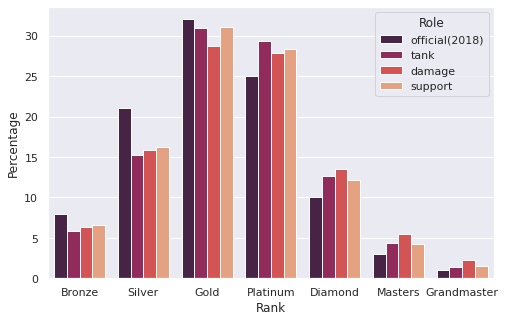

In [20]:
def srToRank(sr):
    """ Map an sr to the corresponding rank"""
    if 0 <= sr and sr < 1500:
        return "Bronze"
    elif sr < 2000:
        return "Silver"
    elif sr < 2500:
        return "Gold"
    elif sr < 3000:
        return "Platinum"
    elif sr < 3500:
        return "Diamond"
    elif sr < 4000:
        return "Masters"
    elif sr <= 5000:
        return "Grandmaster"
    else:
        return "Invalid"

# official estimated rank distribution (2018)
rank_official = pd.Series([8, 21, 32, 25, 10, 3 ,1]).rename(lambda x: RANKS[x])[RANKS]
table = {"official(2018)": rank_official}

# show rank distribution of all roles in the data
for role, [train, test] in DATA.items():
  sr = pd.concat([train["rating"], test["rating"]])
  rank = sr.map(srToRank).astype("category").cat.reorder_categories(RANKS)
  contingency = rank.groupby(rank).count()/len(rank)*100
  table[role] = round(contingency, 1)
df = pd.DataFrame(table)
print(f"\033[1mRank Distribution (percentage):\033[0m\n{df}")

df = df.stack().reset_index().rename(columns={'level_0':'Rank', 'level_1':'Role', 0:'Percentage'})
# bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x = "Rank", y = "Percentage", data = df, hue = "Role", palette = "rocket")

Rank distributions for all three roles in our data are very similar, and compared to the official estimation, they all shifted slightly right (towards higher ranks), which is reasonable considering that SRs have been inflating. Therefore, it's reasonable to assume that our data does not significantly over- or underrepresent certain ranks.

## Modeling

Because most players only play a small subset of all heroes for a non-trivial time, there is a large proportion of missing data. We tried the following approaches to deal with missing data:

1. Impute missing data with minimal value for this feature.

2. Aggregate statistics of the same type across different heroes.

3. Use predictions from the previous approach to impute missing data based on the predicted SR. Specifically, after we obtain initial predictions for SR, we would split the players into several buckets of similar SR, and fill in the missing values with median values in the corresponding bucket. However, this method decreased the performance of our models, and is not included in this final report.

We used **mean squared error (MSE)** as the metric for model performance.

### Method 0: Baseline Models

Three models were attempted:

1.   Always predicting mean
2.   Linear Regression
3.   Lasso Regression


#### Always Predicing Mean

Our baseline model is to always predict the mean of the test set responses.

In [21]:
def baseline(X_test, y_test):
  # Predict with mean
  mean_inp = y_test.mean()
  y_pred = np.asarray([mean_inp] * len(y_test))
  n = y_test.shape[0]

  diff = (y_test - y_pred)**2
  mean = diff.mean()
  sd = diff.std()
  r2 = r2_score(y_test, y_pred)

  # Calculate 95% confidence interval
  low = mean-1.96*sd/np.sqrt(n)
  high = mean+1.96*sd/np.sqrt(n)

  return mean, low, high

#### Linear Regresssion

In [22]:
def lin_reg(X_train, y_train, X_test, y_test):
  reg = LinearRegression().fit(X_train, y_train)
  n = y_test.shape[0]

  # Get MSE and R^2
  y_pred = reg.predict(X_test)
  svr_reg = (y_test - y_pred)**2
  mean = svr_reg.mean()
  sd = svr_reg.std()
  r2 = r2_score(y_test, y_pred)
  print(f"R-squared: {round(r2*100, 1)}%")

  # Calculate 95% confidence interval
  low = mean-1.96*sd/np.sqrt(n)
  high = mean+1.96*sd/np.sqrt(n)

  return mean, low, high

#### Lasso Regression

In [23]:
def las_reg(X_train, y_train, X_test, y_test):
  reg = Lasso().fit(X_train, y_train)
  n = y_test.shape[0]

  # Get MSE and R^2
  y_pred = reg.predict(X_test)
  svr_reg = (y_test - y_pred)**2
  mean = svr_reg.mean()
  sd = svr_reg.std()
  r2 = r2_score(y_test, y_pred)

  # Calculate 95% confidence interval
  low = mean-1.96*sd/np.sqrt(n)
  high = mean+1.96*sd/np.sqrt(n)

  return mean, low, high

#### Results

We first filled missing data with minimal value of the corresponding feature in the training set, then normalized all features and ran the models.

In [24]:
# Normalize each column and fill in missing data with 0
def norm_and_replace(train_df,test_df,verbose=False):
  cols = (train_df.columns.tolist())
  cols.remove("rating")

  # Fill in minimum values from the training set
  train_df = train_df.fillna(train_df.min(axis=0))
  test_df = test_df.fillna(train_df.min(axis=0))

  # Normalization
  scaler = pre.MinMaxScaler()
  train_df[cols] = scaler.fit_transform(train_df[cols])
  test_df[cols] = scaler.transform(test_df[cols])

  return train_df, test_df

# Helper function for data preprocessing
def split_data(train_data, test_data):
  # Normalize data and fill NA with zeros
  train_data, test_data = norm_and_replace(train_data, test_data)

  X_train = train_data.iloc[:, 1:].values
  y_train = train_data.iloc[:, 0].values
  X_test = test_data.iloc[:, 1:].values
  y_test = test_data.iloc[:, 0].values

  return X_train, y_train, X_test, y_test

In [25]:
X_train_all, y_train_all, X_test_all, y_test_all = {}, {}, {}, {}
for role in ROLES:
    X_train_all[role], y_train_all[role], X_test_all[role], y_test_all[role] = split_data(*DATA[role])

In [26]:
baseline_results = dict()
baseline_mses = dict() # for later use

def concat(mean, low, high):
  return  f"{round(mean)} ({round(low)}, {round(high)})"

for role in ROLES:
  baseline_results[role] = dict()
  baseline_mses[role] = dict()
  X_train, y_train, X_test, y_test = X_train_all[role], y_train_all[role], X_test_all[role], y_test_all[role]

  means = baseline(X_test, y_test)
  print(f"\033[1mLinear Regression for {role}:\033[0m")
  linear = lin_reg(X_train, y_train, X_test, y_test)
  print()
  lasso = las_reg(X_train, y_train, X_test, y_test)
  baseline_results[role]["Predicting Mean"] = concat(*means)
  baseline_results[role]["Linear Regression"] = concat(*linear)
  baseline_results[role]["Lasso Regression"] = concat(*lasso)

  baseline_mses[role]["Predicting Mean"] = means[0]
  baseline_mses[role]["Linear Regression"] = linear[0]
  baseline_mses[role]["Lasso Regression"] = lasso[0]

baseline_mses = pd.DataFrame(baseline_mses, index = ["Predicting Mean", "Linear Regression", "Lasso Regression"])
baseline_df = pd.DataFrame(baseline_results)
print("\n\033[1mMSEs of the Baseline Models for each Role (with 95% Confidence Interval)\033[0m")
baseline_df

Linear Regression for tank:
R-squared: 43.7%

Linear Regression for damage:
R-squared: 43.7%

Linear Regression for support:
R-squared: 42.1%


MSEs of the Baseline Models for each Role (with 95% Confidence Interval)


,tank,damage,support
Predicting Mean,"394231 (375828, 412633)","443114 (422605, 463622)","414807 (394941, 434672)"
Linear Regression,"221775 (210710, 232840)","249604 (237036, 262173)","240234 (228302, 252166)"
Lasso Regression,"247391 (234554, 260229)","281517 (267631, 295404)","268079 (254758, 281399)"


The performance of the three baseline models and $R^2$ for linear regressions are shown above. We can see that linear and lasso regression already perform much better than always predicting the test set mean. Linear regression performs the best, with MSEs around **220k-250k**.

### Method 1: Neural Networks

We continued to try to reduce prediction errors by training a neural network, as shown below:



#### Preprocessing and Creating the Neural Network

In [27]:
# Make a dataset file
class overwatchDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y).float()

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        # Get label
        retData = self.X[idx,:]
        retLab = self.Y[idx]

        return retData,retLab

In [28]:
# Create a neural network
dropout = 0.2
class overwatchModule(nn.Module):
  def __init__(self, input_size):
    super(overwatchModule,self).__init__()
    # Create layers
    self.overall = nn.Sequential(
        nn.Linear(input_size,256),
        nn.ReLU(),nn.BatchNorm1d(256),
        nn.Dropout(dropout),nn.Linear(256,512),
        nn.ReLU(),nn.BatchNorm1d(512),
        nn.Dropout(dropout),nn.Linear(512,1024),
        nn.ReLU(),nn.BatchNorm1d(1024),
        nn.Dropout(dropout),nn.Linear(1024,2000),
        nn.ReLU(),nn.BatchNorm1d(2000),
        nn.Dropout(dropout),nn.Linear(2000,4000),
        nn.ReLU(),nn.BatchNorm1d(4000),
        nn.Dropout(dropout),nn.Linear(4000,2000),
        nn.ReLU(),nn.BatchNorm1d(2000),
        nn.Dropout(dropout),nn.Linear(2000,1000),
        nn.ReLU(),nn.BatchNorm1d(1000),
        nn.Dropout(dropout),nn.Linear(1000,256),
        nn.ReLU(),nn.BatchNorm1d(256),
        nn.Dropout(dropout),nn.Linear(256,1))
    
  def forward(self,batchInput):
    overallOutput = self.overall(batchInput)
    return overallOutput

#### Test/Train Functions

In [29]:
# Test Function
def test(model, test_load, device, criterion):
  #Set Model to Eval
  model.eval()
  test_loss = []
  n = 0

  #Go Through Loop
  for batch_idx, (inputs, targets) in enumerate(test_load):
     #Move it to device
     inputs = inputs.to(device)
     targets = torch.unsqueeze(targets,1)
     targets = targets.to(device)

     #Flatten Image
     inputs = inputs.view(inputs.shape[0],-1)

     #Train the Model for output
     outputs = model(inputs)
     loss = criterion(outputs, targets)

     #Get Loss
     test_loss.append(loss.item())

     #Empty Cache And Delete Variables
     del inputs
     del targets
     del outputs
     torch.cuda.empty_cache()

  #Get Standard Deviation
  n = len(test_loss)
  test_loss = np.array(test_loss)
  mean = test_loss.mean()
  sd = test_loss.std()
  low = mean-1.96*sd/np.sqrt(n)
  high = mean+1.96*sd/np.sqrt(n)
  #Calculate Lower, Upper, and Mean
  return mean, low, high

In [30]:
# Train Function
def train(model, optimizer, device, criterion, train_load, test_load,scheduler, epochs, verbose=True):
  #Move and Set Up Variables
  criterion = criterion.to(device)
  model = model.to(device)
  model.train()

  #Get Plot of Test_Acc, Test_Loss
  test_acc_list = []
  test_loss_list = []

  #Main Loop
  for epoch in range(epochs):
    avg_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_load):
      #Move it to device
      inputs = inputs.to(device)
      targets = torch.unsqueeze(targets,1)
      targets = targets.to(device)

      #Flatten Image
      inputs = inputs.view(inputs.shape[0],-1)

      #Train the Model for output
      outputs = model(inputs)
      outputs = outputs.reshape((outputs.shape[0],1))
      loss = criterion(outputs, targets)

      #Learn by Backpropagation
      loss.backward()

      #Optimize the Weights
      optimizer.step()

      #Print Epoch Info
      avg_loss += loss.item()
      if batch_idx % 100 == 0 and batch_idx != 0 and verbose:
        print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_idx, avg_loss/150))
        avg_loss = 0
      
      #Empty Cache, Delete Variables, Reset Optimizer
      optimizer.zero_grad()
      del inputs
      del targets
      del outputs
      torch.cuda.empty_cache()

    #After Epoch Send it Through Test
    mean, low, high = test(model,test_load, device, criterion)
    test_loss_list.append(mean)
    if verbose:
      print("Test Loss: {:.4f} | {:.4f} | {:.4f} ".format(low,mean,high))

    #Step Scheduler
    scheduler.step(mean)

  #Return Test Accuracy and Loss
  return test_loss_list

#### Test Loss

Below is a helper function that displays the rate of change in test loss, by dividing loss by the initial max loss.

In [31]:
def display(test_loss):
  #Normalize Test Loss and Add 0 for Better Display
  test_alt = [i/max(test_loss) for i in test_loss]
  test_alt = test_alt[1:]
  #Print The Results
  plt.plot(test_alt, label = "Test Loss")
  plt.ylabel('Percentage of Max Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

#### Results

Below is another helper function that runs the entire work flow, with learning rate $= 0.001$, epochs $= 50$, Adam optimizer, and an adaptive learning rate scheduler.

In [32]:
DATA_PATH = "https://raw.githubusercontent.com/hachiyuki8/ow-stats-analysis/master/norm/"

def overall_net(role, verbose=False):
  # train_data = pd.read_csv(DATA_PATH + role + "_train.csv")
  # test_data = pd.read_csv(DATA_PATH + role + "_test.csv")
  # X_train, y_train, X_test, y_test = split_data(train_data, test_data)
  X_train, y_train, X_test, y_test = X_train_all[role], y_train_all[role], X_test_all[role], y_test_all[role]

  # Load training data
  train_data = overwatchDataset(X_train,y_train)
  trainLoader = utils.data.DataLoader(train_data, batch_size=64,
                                      shuffle=True,drop_last=True)

  #Load test data
  test_data = overwatchDataset(X_test,y_test)
  testLoader = utils.data.DataLoader(test_data, batch_size=64,
                                     shuffle=False,drop_last=True)
  
  # Hyperparameters
  learn_rate = 0.001
  epochs = 50

  # Model configurations
  model = overwatchModule(X_train.shape[1])
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(),lr=learn_rate)
  device = "cuda" if torch.cuda.is_available() else "cpu"
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.2,patience=4,verbose=verbose)

  test_loss_list = train(model, optimizer, device, criterion, trainLoader, testLoader, scheduler, epochs, verbose=verbose)
  print("Test Loss:")
  display(test_loss_list)

  return min(test_loss_list)

Training Neural Network on tank
Test Loss:


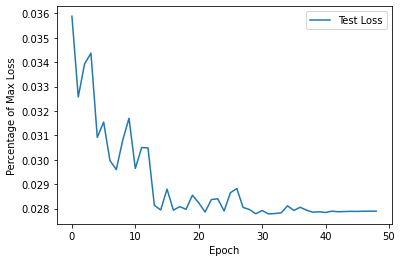

In [ ]:
min_losses = dict()

# Tank
role = "tank"
print(f"\033[1mTraining Neural Network on {role}\033[0m")
min_losses[role] = overall_net(role, verbose = False)

Training Neural Network on damage
Test Loss:


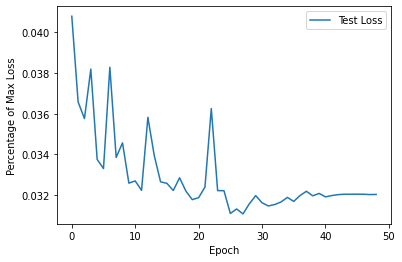

In [ ]:
# Damage
role = "damage"
print(f"\033[1mTraining Neural Network on {role}\033[0m")
min_losses[role] = overall_net(role, verbose = False)

Training Neural Network on support
Test Loss:


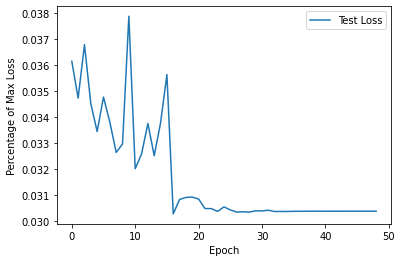

In [ ]:
# Support
role = "support"
print(f"\033[1mTraining Neural Network on {role}\033[0m")
min_losses[role] = overall_net(role, verbose = False)

In [ ]:
nn_mses = pd.DataFrame(min_losses, index = ["Neural Network"])
print("\n\033[1mMSEs of the Neural Network for each Role\033[0m")
nn_mses.astype(int)


MSEs of the Neural Network for each Role


,tank,damage,support
Neural Network,174315,198937,186477


The minimum losses of the neural network for all three roles, displayed above, shows further improvement from linear and lasso regression, with MSEs around **174k-200k**.

### Method 2: Gradient Boosting


#### Model Parameters and Results

The next method we tried was gradient boosted trees, with parameters tuned via standard cross-validation. The models with best parameters for each role are shown below:

In [34]:
GB_model_params = {}
GB_model_params["tank"] = {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9, 'learning_rate': 0.05}
GB_model_params["damage"] = {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'learning_rate': 0.1}
GB_model_params["support"] = {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'learning_rate': 0.1}

In [35]:
def run_gb(X_train, y_train, X_test, y_test, kwargs={}):
    gb = GradientBoostingRegressor(random_state = 69, **kwargs)
    gb.fit(X_train, y_train)
    
    pred = gb.predict(X_test)
    gb_mse = metrics.mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"R-squared: {round(r2*100, 1)}%")
    print(f"MSE: {round(gb_mse, 2)}")

    return gb, gb_mse

In [36]:
gb_mses = {}
gb_models = {}
for role in ROLES:
  print(f"\033[1mGradient Boosting for {role}:\033[0m")
  model, score = run_gb(X_train_all[role], y_train_all[role], X_test_all[role], y_test_all[role], kwargs=GB_model_params[role])
  gb_mses[role] = score
  gb_models[role] = model
  print()

gb_mses = pd.DataFrame(gb_mses, index = ["Gradient Boosting"])
print("\033[1mPerformance of Gradient Boosting\033[0m")
gb_mses.astype(int)

Gradient Boosting for tank:
R-squared: 54.9%
MSE: 177841.56

Gradient Boosting for damage:
R-squared: 54.2%
MSE: 202815.78

Gradient Boosting for support:
R-squared: 55.1%
MSE: 186302.6


Performance of Gradient Boosting


,tank,damage,support
Gradient Boosting,177841,202815,186302


With MSEs around **177k to 203k**, the performance of gradient boosting is very close to that of the nerual network.

####Feature Importances

With Gradient Boosting, we can examine feature importances for the fitted models. Since there are too many features with relatively high importances, we will group the top 40 statistics by the corresponding heroes for an easily interpretable visualization.






In [ ]:
take_name = re.compile(r"([a-zA-Z0-9]+)_.*")
role = "tank"

def draw_importances(role, k=40):
  columns = list(DATA[role][0].columns)
  columns.remove('rating')
  importances = sorted(list(zip(gb_models[role].feature_importances_, columns)), reverse=True)

  f, ax = plt.subplots(figsize=(18,7))
  barlist = plt.bar([x[1] for x in importances[:k]], [x[0] for x in importances[:k]])
  plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False)

  temp_c = Counter()
  for i in range(k):
      name = take_name.match(importances[i][1]).groups()[0]
      temp_c[name] += 1
      
  cmap = plt.get_cmap('Accent')
  names = temp_c.keys()
  colormap = dict(zip(names, sns.color_palette()[:len(names)]))

  for i in range(k):
      name = take_name.match(importances[i][1]).groups()[0]
      barlist[i].set_color(colormap[name])

  hndls = []
  for k, v in colormap.items():
      patch = mpatches.Patch(color=v, label=k)  
      hndls.append(patch)
      
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.legend(handles=hndls, fontsize=20)
  plt.title(f"[{role.upper()}] Feature Imprortances (First 40) with Gradient Boosting", fontsize=22)
  plt.show()

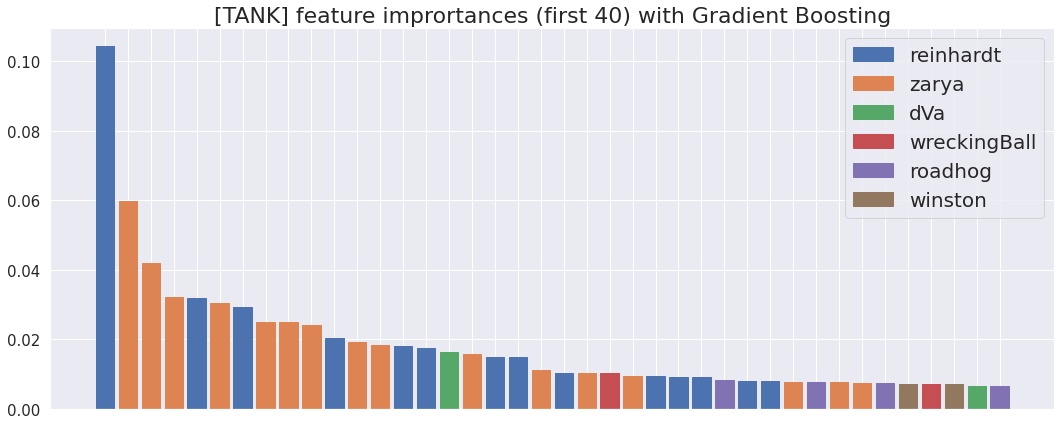

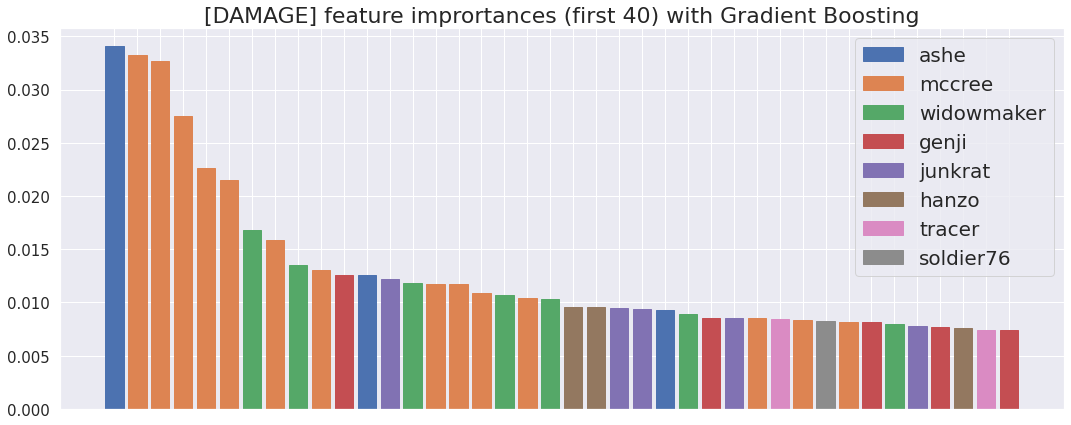

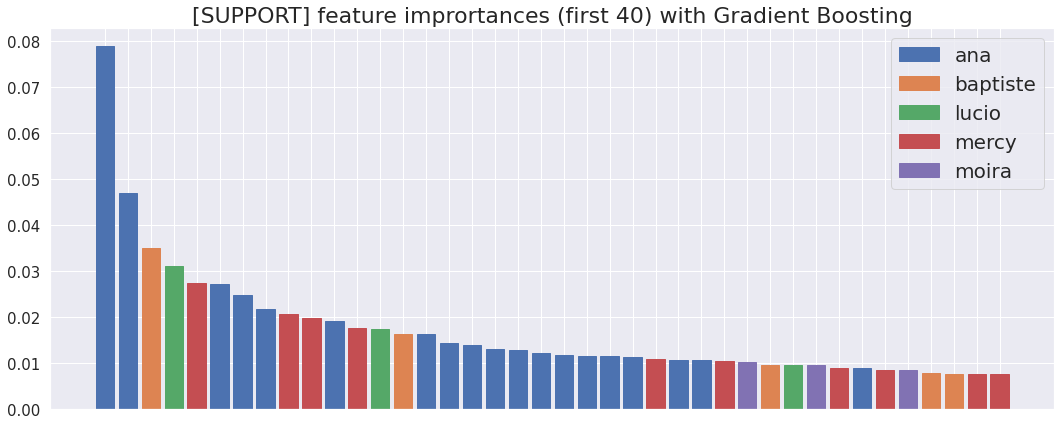

In [ ]:
for role in ROLES:
  draw_importances(role)

We can see that feature importances tend to cluster around certain heroes for all the roles. Specifically, the first 40 features for tank contain the majority of statistics for two hereos, **Reinhart and Zarya**. Similar patterns can be observed for other roles as well (**McCree** for damage, **Ana** for support). 

This might suggest that **playing certain heroes** is a stronger indicator of higher SR than certain statistics. The observation is also consistent with the presence of **meta (preferred or overpowered heroes or team compositions)** in Overwatch. 

### Method 3: Aggregate Statistics

Finally, we aggregated the columns in the following way:

(Aggregation was done per-role on data without feature scaling.)

1. Discard hero-specific statistics for all heroes.

2. For each common statistic, average across all heroes.

Taking average deaths per 10 minutes on tank as an example. Instead of having eight features for average deaths, one for each tank, the new data frame has only one such feature. If a player has only played two tanks, with five and seven average deaths per 10 minutes respectively, then the corresponding value in the new data frame is $\frac{5+7}{2}=6$.

After aggregating the columns, new features with more than 30% missing data were dropped. The remaining missing values were filled with median of that feature. [**[Code](https://github.com/hachiyuki8/ow-stats-analysis/blob/joanna/aggregate.py)**]

In [ ]:
PICKLE_PATH = "https://github.com/hachiyuki8/ow-stats-analysis/blob/joanna/aggregated/"

# load the aggregated data
tank_train_X = pickle.load(urlopen(PICKLE_PATH + "tank_train_X.pickle?raw=true")) 
tank_train_y = pickle.load(urlopen(PICKLE_PATH + "tank_train_y.pickle?raw=true")) 
tank_test_X = pickle.load(urlopen(PICKLE_PATH + "tank_test_X.pickle?raw=true")) 
tank_test_y = pickle.load(urlopen(PICKLE_PATH + "tank_test_y.pickle?raw=true")) 

damage_train_X = pickle.load(urlopen(PICKLE_PATH + "damage_train_X.pickle?raw=true")) 
damage_train_y = pickle.load(urlopen(PICKLE_PATH + "damage_train_y.pickle?raw=true")) 
damage_test_X = pickle.load(urlopen(PICKLE_PATH + "damage_test_X.pickle?raw=true")) 
damage_test_y = pickle.load(urlopen(PICKLE_PATH + "damage_test_y.pickle?raw=true")) 

support_train_X = pickle.load(urlopen(PICKLE_PATH + "support_train_X.pickle?raw=true")) 
support_train_y = pickle.load(urlopen(PICKLE_PATH + "support_train_y.pickle?raw=true")) 
support_test_X = pickle.load(urlopen(PICKLE_PATH + "support_test_X.pickle?raw=true")) 
support_test_y = pickle.load(urlopen(PICKLE_PATH + "support_test_y.pickle?raw=true")) 

data = {"tank": (tank_train_X, tank_train_y, tank_test_X, tank_test_y),
        "damage": (damage_train_X, damage_train_y, damage_test_X, damage_test_y),
        "support": (support_train_X, support_train_y, support_test_X, support_test_y)}

Four models were then trained on the aggregated data for each role: linear regression, random forest, gradient boosting, and k-nearest neighbors. Hyperparameters are tuned via 200 iterations of 5-fold cross validation based on randomized search. **[[Code](https://github.com/hachiyuki8/ow-stats-analysis/blob/joanna/model.py)]**

#### Linear Regression 

##### **Model Summaries and Results**

In [ ]:
def lin_reg_new(X_train, y_train, X_test, y_test):
  reg = LinearRegression().fit(X_train, y_train)
  n = y_test.shape[0]

  # Get MSE and R^2
  y_pred = reg.predict(X_test)
  svr_reg = (y_test - y_pred)**2
  mean = svr_reg.mean()
  sd = svr_reg.std()
  r2 = r2_score(y_test, y_pred)
  print(f"R-squared: {round(r2*100, 1)}%")
  idx = reg.coef_.argsort()
  print(pd.DataFrame({"Stats": X_train.columns[idx], "Coefficients": reg.coef_[idx]}))

  return mean

lr_mses = dict()
for role in ROLES:
  print(f"\033[1mLinear Regression for {role}:\033[0m")
  lr_mses[role] = lin_reg_new(*data[role])
  print()

lr_mses = pd.DataFrame(lr_mses, index = ["Linear Regression"])
print("\033[1mPerformance of Linear Regression on Aggregated Data\033[0m")
round(lr_mses)

Linear Regression for tank:
R-squared: 23.7%
                          Stats  Coefficients
0          soloKillsAvgPer10Min   -162.374318
1     objectiveKillsAvgPer10Min    -93.598387
2    timeSpentOnFireAvgPer10Min     -4.181543
3      objectiveTimeAvgPer10Min     -3.080739
4  barrierDamageDoneAvgPer10Min      0.097651
5     heroDamageDoneAvgPer10Min      0.177626
6             deathsAvgPer10Min      9.510600
7         finalBlowsAvgPer10Min     20.280015
8       eliminationsAvgPer10Min     29.692799
9                weaponAccuracy   1105.574163

Linear Regression for damage:
R-squared: 28.6%
                           Stats  Coefficients
0      objectiveKillsAvgPer10Min   -166.239110
1           soloKillsAvgPer10Min    -85.166761
2          finalBlowsAvgPer10Min    -10.038445
3       objectiveTimeAvgPer10Min     -5.242997
4     timeSpentOnFireAvgPer10Min     -2.205474
5      heroDamageDoneAvgPer10Min     -0.019400
6   barrierDamageDoneAvgPer10Min      0.062894
7        criticalHitsAvgP

,tank,damage,support
Linear Regression,300964.0,316444.0,334662.0


With MSEs around **300k-335k**, the performance is worse than linear regression on unaggregated data, which makes sense since we discarded hero-specific statistics which could contain important signals, but is still better than predicting means.

#### Random Forest, Gradient Boosting, K-Nearest Neighbors

The best parameters for latter three models are shown below (with pre-saved MSEs):

In [ ]:
# best parameters and pre-saved MSEs
tank_models = {"RF": RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse', max_depth=33, 
                                           max_features='sqrt', max_leaf_nodes=None, max_samples=None, 
                                           min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, 
                                           min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=1419, 
                                           n_jobs=None, oob_score=False, random_state=69, verbose=0, warm_start=False), 
               "GB": GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse', init=None, 
                                               learning_rate=0.01, loss='ls', max_depth=17, max_features='sqrt', 
                                               max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                               min_samples_leaf=1, min_samples_split=10, min_weight_fraction_leaf=0.0, 
                                               n_estimators=742, n_iter_no_change=None, random_state=69, subsample=1.0, 
                                               tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False), 
               "KNN": KNeighborsRegressor(algorithm='ball_tree', leaf_size=64, metric='minkowski', metric_params=None, 
                                          n_jobs=None, n_neighbors=40, p=2, weights='distance'), 
               "MSE": [244123.16048430157, 244887.39789141578, 251571.78548830753]}

damage_models = {"RF": RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse', max_depth=33, 
                                             max_features='sqrt', max_leaf_nodes=None, max_samples=None, 
                                             min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, 
                                             min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=1419, 
                                             n_jobs=None, oob_score=False, random_state=69, verbose=0, warm_start=False),
                 "GB": GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse', init=None,
                                                 learning_rate=0.01, loss='ls', max_depth=41, max_features='sqrt', 
                                                 max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                                 min_samples_leaf=4, min_samples_split=10, min_weight_fraction_leaf=0.0, 
                                                 n_estimators=1449, n_iter_no_change=None, random_state=69, subsample=1.0, 
                                                 tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False),
                 "KNN": KNeighborsRegressor(algorithm='kd_tree', leaf_size=10, metric='minkowski', metric_params=None, 
                                            n_jobs=None, n_neighbors=25, p=1, weights='distance'),
                 "MSE": [250032.93578668233, 247365.3741125667, 269458.98917060153]}

support_models = {"RF": RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse', max_depth=64, 
                                              max_features='sqrt', max_leaf_nodes=None, max_samples=None, 
                                              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, 
                                              min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=994, 
                                              n_jobs=None, oob_score=False, random_state=69, verbose=0, warm_start=False),
                  "GB": GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse', init=None, 
                                                  learning_rate=0.01, loss='ls', max_depth=17, max_features='sqrt', 
                                                  max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                                  min_samples_leaf=1, min_samples_split=10, min_weight_fraction_leaf=0.0, 
                                                  n_estimators=742, n_iter_no_change=None, random_state=69, subsample=1.0, 
                                                  tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False),
                  "KNN": KNeighborsRegressor(algorithm='ball_tree', leaf_size=33, metric='minkowski', metric_params=None, 
                                             n_jobs=None, n_neighbors=35, p=1, weights='distance'),
                  "MSE": [272529.0814005239, 270516.3864121574, 285994.1570905974]}

# To be used later
aggregated_mses = {"tank": tank_models["MSE"], "damage": damage_models["MSE"], "support": support_models["MSE"]}
aggregated_mses = pd.DataFrame(aggregated_mses, index = ["Random Forest", "Gradient Boosting", "K-Nearest Neighbors"])

In [ ]:
# Fit the best model under each role, takes a few minutes to run
tank_models["RF"].fit(tank_train_X, tank_train_y)
damage_models["GB"].fit(damage_train_X, damage_train_y)
support_models["GB"].fit(support_train_X, support_train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=17, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=10, min_weight_fraction_leaf=0.0,
                          n_estimators=742, n_iter_no_change=None,
                          presort='deprecated', random_state=69, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

##### Results

In [ ]:
# Check MSE and rMSE for the best models
errors = dict()
pred = {"tank": tank_models["RF"].predict(tank_test_X),
        "damage": damage_models["GB"].predict(damage_test_X),
        "support": support_models["GB"].predict(support_test_X)}
test = {"tank": tank_test_y,
        "damage": damage_test_y,
        "support": support_test_y}

for role in ROLES:
  errors[role] = {"MSE":  round(metrics.mean_squared_error(test[role], pred[role])),
                  "RMSE": round(metrics.mean_squared_error(test[role], pred[role])**0.5)}

errors_df = pd.DataFrame(errors)
print("\033[1mPerformance of Best Models for each Role on Aggregated Data\033[0m")
errors_df

Performance of Best Models for each Role on Aggregated Data


,tank,damage,support
MSE,244123,247366,270524
RMSE,494,497,520


With MSEs around **244k-270k**, the performance is generally worse than models on unaggregated data. However, by examining feature importances, we can see which types of statistics are the most important in these models. 

##### Feature Importances

In [ ]:
# calculate permutation feature importances
tank_result = permutation_importance(tank_models["RF"], tank_test_X, tank_test_y, random_state=69)
tank_idx = tank_result.importances_mean.argsort()

damage_result = permutation_importance(damage_models["GB"], damage_test_X, damage_test_y, random_state=69)
damage_idx = damage_result.importances_mean.argsort()

support_result = permutation_importance(support_models["GB"], support_test_X, support_test_y, random_state=69)
support_idx = support_result.importances_mean.argsort()

Text(0.5, 1.0, '[SUPPORT] Permutation Feature Importances (on Test Set)')

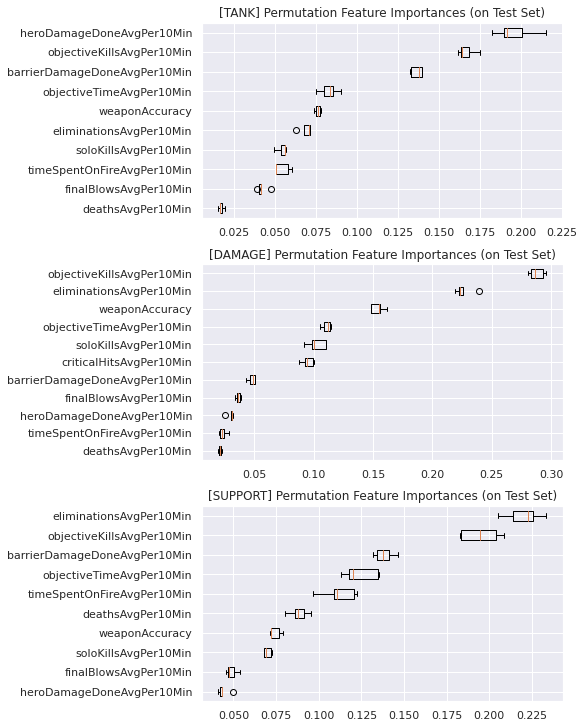

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(8, 10)
ax.axis('off')
grid = gridspec.GridSpec(nrows = 3, ncols = 1, figure = fig)

ax1 = fig.add_subplot(grid[0])
ax1.boxplot(tank_result.importances[tank_idx].T, vert=False, labels=tank_test_X.columns[tank_idx])
ax1.set_title("[TANK] Permutation Feature Importances (on Test Set)")

ax2 = fig.add_subplot(grid[1])
ax2.boxplot(damage_result.importances[damage_idx].T, vert=False, labels=damage_test_X.columns[damage_idx])
ax2.set_title("[DAMAGE] Permutation Feature Importances (on Test Set)")

ax3 = fig.add_subplot(grid[2])
ax3.boxplot(support_result.importances[support_idx].T, vert=False, labels=support_test_X.columns[support_idx])
ax3.set_title("[SUPPORT] Permutation Feature Importances (on Test Set)")

For each model, the features with relatively high importance are as follows:
- **Tank**: hero damage done, objective kills, barrier damage done
- **Damage**: objective kills, eliminations, weapon accuracy
- **Support**: eliminations, objective kills, barrier damage done

Although feature importance is model-specific and doesn't necessarily represent the actual predictive value, we can still extract some interesting patterns: 
- **Objective kills**, usually not considered as important, is an important features in all three models.
- **Hero/Barrier damage done** and **eliminations** both reflect amount of damage output, but the former is important for tank and support, while the latter is important for damage.
- **Weapon accuracy** is more important for damage than for tank and support, which is within expectation.
- **Final blows** is usually considered an important statistic, especially for damage, but it's relatively unimportant in all three models.


## Conclusion

Below is the performance of all models attempted:

In [ ]:
# TO-DO: MSE and rMSE table
print("\033[1mPerformance of Models on Unaggregated Data\033[0m")
pd.concat([baseline_mses, nn_mses, gb_mses]).astype(int).style.highlight_min(color = 'lightgreen', axis = 0)

Performance of Models on Unaggregated Data


,tank,damage,support
Predicting Mean,394230,443113,414806
Linear Regression,221775,249604,240234
Lasso Regression,247391,281517,268078
Neural Network,174315,198937,186477
Gradient Boosting,177841,202815,186302


In [ ]:
print("\033[1mPerformance of Models on Aggregated Data\033[0m")
pd.concat([lr_mses, aggregated_mses]).astype(int).style.highlight_min(color = 'lightgreen', axis = 0)

Performance of Models on Aggregated Data


,tank,damage,support
Linear Regression,300963,316443,334662
Random Forest,244123,250032,272529
Gradient Boosting,244887,247365,270516
K-Nearest Neighbors,251571,269458,285994


In [ ]:
print("\033[1mMagnitude of Error: Root MSEs of the Best Models Overall\033[0m")
(pd.concat([nn_mses, gb_mses])**0.5).astype(int)

Magnitude of Error: Root MSEs of the Best Models Overall


,tank,damage,support
Neural Network,417,446,431
Gradient Boosting,421,450,431


Models on unaggregated data in general perform better than those on aggregated data. The **neural network** has the best performance on all three roles. Gradient boosting on unaggregated data has a comparable performance, while providing some interpretability: apparently, feature importances **cluster more around heroes than around certain types of statistics**. Lastly, models on aggregated data allow us to see the relative importance of different types of common statistics, where we observed patterns both within and out of expectation. 

The average magnitude of prediction error for the best models, as measure by root MSE, is around **417-450** depending on roles. Although it improved quite a lot compared to just predicting the mean, the errors are still rather large. The large errors can be partially attributed to the natural variability or randomness in the data, i.e. **irreducible errors**. Since Overwatch is highly team-based, it makes sense that whether a player wins or loses a match is related to not only their own performance. Therefore, while a player's statistics may be indicative of a general range for their SR, their statistics alone is not enough to generate a more accurate prediction.

There might not be much room for further investigation regarding predicting SR other than trying different imputation methods, since there's no means of accessing additional data such as match information. However, one can look into ways of **predicting the outcome of a match from information on all 12 players**, and see if any signals regarding team compositions or player statistics are picked up.